## Dataset Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from keras.preprocessing import image
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [ ]:
p = Path('/content/drive/My Drive/images_local_features/')
print(p)
dirs = p.glob('*')
#labels_dict = {'cats':0, 'dogs':1, 'horses':2, 'humans': 3}
labels_dict = {'fake':0, 'real':1}
print(labels_dict)

image_data = []
labels = []

for folder_dir in dirs:
    label = str(folder_dir).split('/')[-1]
    print(label)
    for img_path in folder_dir.glob("*.png"):
        img = io.imread(img_path)
        #img_array = image.img_to_array(img)
        image_data.append(img)
        labels.append(labels_dict[label])


/content/drive/My Drive/images_local_features
{'fake': 0, 'real': 1}
fake
real


In [ ]:
p = '/content/drive/My Drive/images_local_features/'
folders=os.listdir(p)
labels_dict = {'fake':0, 'real':1}
X=np.zeros((0,800*1200),dtype=np.uint8)
Y=[]
for folder in folders:
  files=os.listdir(p+folder)
  for file in files:
    img=io.imread(p+folder+"/"+file)
    #print(img.shape)
    img = img.flatten()
    X=np.row_stack((X,img.flatten()))
    Y.append(labels_dict[folder])

In [ ]:
image_data[0].shape

(800, 1200)

In [ ]:
X.shape

(1, 960000)

In [ ]:
## Convert data into numpy array
image_data = np.array(image_data, dtype=np.uint8)
labels = np.array(labels)

print(image_data.shape, labels.shape)

(825, 800, 1200) (825,)


In [ ]:
## Randomly shuffle data

import random
combined = list(zip(image_data, labels))
random.shuffle(combined)

image_data[:], labels[:] = zip(*combined)
print('done')

done


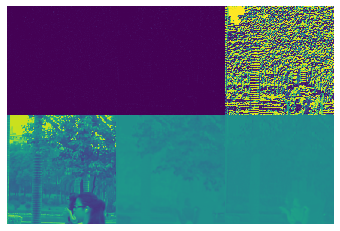

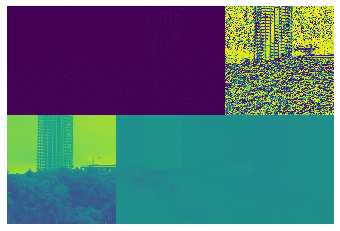

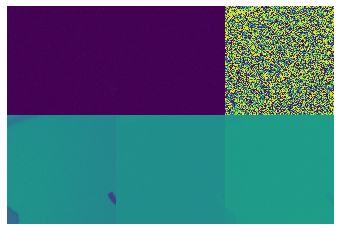

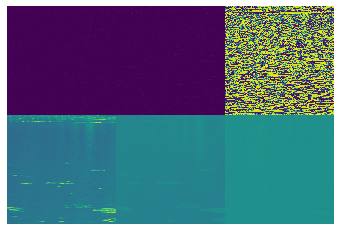

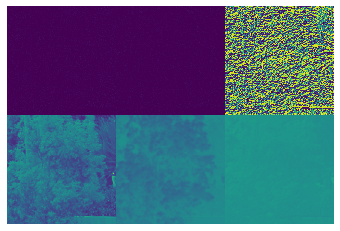

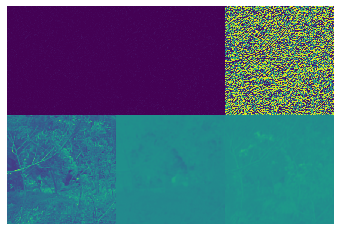

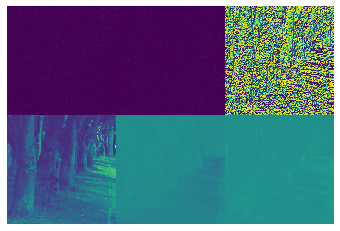

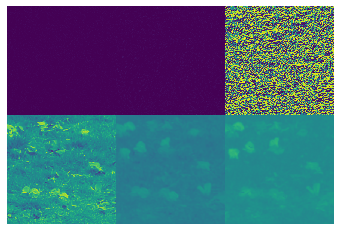

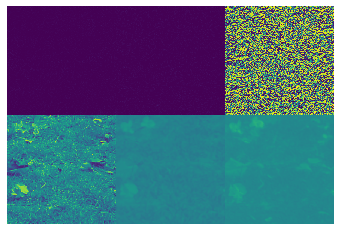

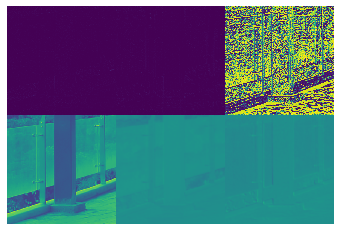

In [ ]:
## Visualize the data

def drawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

for i in range(10):
    drawImg(image_data[i])

## SVM Classifier

In [ ]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0

    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0

        loss += .5*np.dot(W,W.T)

        m = X.shape[0]

        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))

        return loss[0][0]

    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):

        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]

        n = learning_rate
        c = self.C

        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0

        #Initial Loss

        #Training from here...
        # Weight and Bias update rule
        losses = []

        for i in range(maxItr):
            #Training Loop

            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)

            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0

                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)

                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]

                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb


        self.W = W
        self.b = bias
        return W,bias,losses

In [ ]:
## Data conversion for One vs One classification

M = image_data.shape[0]
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(825, 960000)
(825,)


In [ ]:
number_of_classes = len(np.unique(labels))
print(number_of_classes)

2


In [ ]:
def classWiseData(x, y):
    data = {}

    for i in range(number_of_classes):
        data[i] = []

    for i in range(x.shape[0]):
        data[y[i]].append(x[i])

    for k in data.keys():
        data[k] = np.array(data[k])

    return data

In [ ]:
data = classWiseData(image_data, labels)

In [ ]:
print(data[0].shape[0])
print(data[1].shape[0])


226
599


In [ ]:
"""Combines data of two classes into a single matrix"""
def getDataPairForSVM(d1,d2):

    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]

    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))

    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2

    data_labels[:l1] = -1
    data_labels[l1:] = 1

    return data_pair, data_labels

In [ ]:
xp, yp = getDataPairForSVM(data[0], data[1])

In [ ]:
image_data

(825, 960000)

In [ ]:

xp, X_test, yp, y_test = train_test_split(xp, yp, test_size=0.3, random_state=42)

## Training nC2 SVM

In [ ]:
mySVM = SVM()
w,b,loss = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=5)
plt.plot(loss)

In [ ]:
def predict(img):
  count = np.zeros((number_of_classes,))
  if img.shape[0]>1:
    img=img.flatten()
  res = np.dot(img,w.T) + b
  if res >= 0:
      z=1
  else:
      z=-1
  if z==1:
      count[j] += 1
  else:
      count[i] += 1




In [ ]:
def predict_all(data):
  mylabels=[]
  for i in range(data.shape[0]):
    img=data[i,:]
    label=predict(img)
    final_prediction = np.argmax(count)
    return final_prediction
    mylabels.append(label)
  return mylabels


In [ ]:
my_predictions=predict_all(X_test)
print(len(my_predictions))

248


In [ ]:
print(classification_report(y_test, my_predictions, labels=[0, 1]))
print(confusion_matrix(y_test,my_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.71      1.00      0.83       177

    accuracy                           0.71       248
   macro avg       0.36      0.50      0.42       248
weighted avg       0.51      0.71      0.59       248

[[  0  71]
 [  0 177]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def trainSVMs(x,y):
    svm_classifiers = {}

    for i in range(number_of_classes):
        svm_classifiers[i] = {}
        for j in range(i+1, number_of_classes):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair, ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)

            plt.plot(loss)
            plt.show()

    return svm_classifiers

In [ ]:
svm_classifiers = trainSVMs(image_data, labels)

In [ ]:
cats_dogs = svm_classifiers[0][1]
cats_humans = svm_classifiers[0][3]
print(cats_dogs[0].shape)
print(cats_dogs[1])

In [ ]:
X_train.shape

(825, 960000)

## Prediction

In [ ]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z >= 0:
        return 1
    else:
        return -1

In [ ]:
def predict(x):

    count = np.zeros((number_of_classes,))

    for i in range(number_of_classes):
        for j in range(i+1, number_of_classes):
            w,b = svm_classifiers[i][j]

            #Take a majority prediction
            z = binaryPredict(x,w,b)

            if z==1:
                count[j] += 1
            else:
                count[i] += 1

    final_prediction = np.argmax(count)
    return final_prediction

In [ ]:
print(predict(image_data[0]))
print(labels[0])

0
0


In [ ]:
def accuracy(x,y):

    pred = []
    count=0

    for i in range(x.shape[0]):
        prediction = predict(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1

    return count/x.shape[0], pred

In [ ]:
acc, ypred = accuracy(image_data, labels)
print(acc)

0.6002475247524752


## Using scikit

In [ ]:
from sklearn import svm

In [ ]:
svm_classifier = svm.SVC(kernel='linear', C=1.0)
svm_classifier.fit(image_data, labels)
ypred_sklearn = svm_classifier.predict(image_data)
svm_classifier.score(image_data,labels)

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
"""Use this method directly - """
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### SVM classifier

In [ ]:
cnf_matrix = confusion_matrix(labels, ypred)
print(cnf_matrix)

In [ ]:
plot_confusion_matrix(cnf_matrix, [0,1,2,3],normalize=False,title='Confusion matrix',cmap=plt.cm.Blues)

### Sci-kit Learn

In [ ]:
cnf_matrix_sklearn = confusion_matrix(labels, ypred_sklearn)
print(cnf_matrix_sklearn)

In [ ]:
plot_confusion_matrix(cnf_matrix_sklearn, [0,1,2,3],normalize=False,title='Confusion matrix',cmap=plt.cm.Blues)